In [23]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
mpl.rcParams['figure.figsize'] = (15,8)
mpl.rcParams['axes.grid'] = False

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/subhmm/MeanEquatorTemperature/main/Mean_Eq.csv', index_col='month')
df

,1,2,3,5,7,10,20,30,50,70,100,125,150,175,200,225,250,ENSO 3.4 Anomaly
month,,,,,,,,,,,,,,,,,,
1979-01,270.00,268.64,260.98,245.88,237.64,230.75,219.01,212.99,206.00,196.89,190.64,197.41,205.39,212.98,219.98,226.35,232.13,NaN
1979-02,276.98,274.33,262.37,245.62,236.56,228.61,217.18,211.56,204.20,196.32,191.05,196.76,204.64,212.44,219.62,226.12,231.98,NaN
1979-03,274.81,276.09,267.97,251.23,240.71,232.58,220.38,213.30,204.92,197.01,190.96,196.86,204.81,212.65,219.89,226.42,232.30,NaN
1979-04,272.52,272.11,263.99,250.66,243.72,235.46,223.63,215.93,206.80,198.18,191.38,196.76,204.89,212.82,220.13,226.72,232.63,NaN
1979-05,269.69,270.55,263.53,248.56,241.75,236.05,224.14,216.42,207.51,199.17,192.80,197.57,205.22,212.95,220.18,226.73,232.62,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08,264.91,259.01,249.97,236.56,232.11,228.60,220.42,216.00,209.63,201.67,194.41,199.17,206.17,213.30,220.10,226.42,232.22,-0.69
2020-09,265.27,263.68,254.02,240.74,235.60,230.54,220.44,215.31,208.56,201.77,194.58,199.27,206.03,213.06,219.90,226.28,232.13,-0.96
2020-10,264.45,262.80,255.15,242.78,237.87,232.45,221.93,216.13,208.35,202.27,192.94,198.30,205.53,212.94,219.96,226.39,232.26,-1.42


In [3]:
df = df[df['ENSO 3.4 Anomaly'].notna()]
# df

In [4]:
###TRAIN-TEST SPLIT
df_train,df_test = df.iloc[:444,:],df.iloc[444:,:]

In [5]:
print(df_test.shape)
df_train.shape

(24, 18)


(444, 18)

In [6]:
scaler = MinMaxScaler()
scaler.fit(df_train)

MinMaxScaler()

In [7]:
scaled_train = scaler.transform(df_train)
scaled_train.shape

(444, 18)

In [8]:
scaled_train

array([[0.91717283, 0.58661239, 0.37934186, ..., 0.31625835, 0.31221719,
        0.47467167],
       [0.98729983, 0.91994573, 0.66864717, ..., 0.30512249, 0.30316742,
        0.44277674],
       [0.98012148, 0.90411578, 0.91316271, ..., 0.39643653, 0.40497738,
        0.44277674],
       ...,
       [0.66979569, 0.55042967, 0.41636197, ..., 0.50334076, 0.50678733,
        0.60787992],
       [0.55770293, 0.5042967 , 0.39396709, ..., 0.62806236, 0.63574661,
        0.63227017],
       [0.33186085, 0.05065581, 0.0274223 , ..., 0.56347439, 0.56334842,
        0.62664165]])

In [9]:
scaled_train[:,0].shape

(444,)

In [10]:
scaled_test = scaler.transform(df_test)
scaled_test.shape

(24, 18)

In [11]:
def predictor(idx):
    x_train = scaled_train
    y_train = scaled_train[:,idx]
    x_test = scaled_test
    y_test = scaled_test[:,idx]
    win_length = 1
    batch_size = 1
    features = 18
    train_generator = TimeseriesGenerator(x_train,y_train,length=win_length,sampling_rate=1,batch_size = batch_size)
    test_generator = TimeseriesGenerator(x_test,y_test,length=win_length,sampling_rate=1,batch_size = batch_size)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(128,input_shape=(win_length,features),return_sequences=True))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
    model.add(tf.keras.layers.LSTM(128,return_sequences=True))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.LSTM(64,return_sequences=False))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(),
              metrics=[tf.metrics.MeanAbsoluteError()])
    history = model.fit(train_generator, epochs=10, validation_data=test_generator,
                              shuffle=False)
    predictions = model.predict(test_generator)
    return predictions

In [12]:
predictor(0)

Epoch 1/10
443/443 [==============================] - 6s 5ms/step - loss: 0.0690 - mean_absolute_error: 0.1854 - val_loss: 0.0359 - val_mean_absolute_error: 0.1556
Epoch 2/10
443/443 [==============================] - 1s 3ms/step - loss: 0.0216 - mean_absolute_error: 0.1139 - val_loss: 0.0161 - val_mean_absolute_error: 0.1020
Epoch 3/10
443/443 [==============================] - 1s 3ms/step - loss: 0.0163 - mean_absolute_error: 0.1006 - val_loss: 0.0163 - val_mean_absolute_error: 0.1014
Epoch 4/10
443/443 [==============================] - 2s 4ms/step - loss: 0.0137 - mean_absolute_error: 0.0890 - val_loss: 0.0151 - val_mean_absolute_error: 0.0971
Epoch 5/10
443/443 [==============================] - 1s 3ms/step - loss: 0.0133 - mean_absolute_error: 0.0894 - val_loss: 0.0144 - val_mean_absolute_error: 0.0951
Epoch 6/10
443/443 [==============================] - 1s 3ms/step - loss: 0.0138 - mean_absolute_error: 0.0903 - val_loss: 0.0141 - val_mean_absolute_error: 0.0956
Epoch 7/10
443/4

array([[0.7570215 ],
       [0.7948433 ],
       [0.67662966],
       [0.5814223 ],
       [0.53186405],
       [0.47491997],
       [0.5510148 ],
       [0.62513596],
       [0.69156164],
       [0.50741667],
       [0.47158694],
       [0.6522589 ],
       [0.7316091 ],
       [0.66404396],
       [0.49246764],
       [0.40699136],
       [0.35990095],
       [0.37683564],
       [0.46394163],
       [0.65676314],
       [0.59169656],
       [0.5159852 ],
       [0.41337624]], dtype=float32)

In [13]:
results = []

In [14]:
for x in range(18):
    results.append(predictor(x))

Epoch 1/10
443/443 [==============================] - 5s 5ms/step - loss: 0.0652 - mean_absolute_error: 0.1818 - val_loss: 0.0374 - val_mean_absolute_error: 0.1583
Epoch 2/10
443/443 [==============================] - 2s 4ms/step - loss: 0.0224 - mean_absolute_error: 0.1175 - val_loss: 0.0220 - val_mean_absolute_error: 0.1221
Epoch 3/10
443/443 [==============================] - 1s 3ms/step - loss: 0.0181 - mean_absolute_error: 0.1032 - val_loss: 0.0168 - val_mean_absolute_error: 0.1037
Epoch 4/10
443/443 [==============================] - 1s 3ms/step - loss: 0.0149 - mean_absolute_error: 0.0929 - val_loss: 0.0156 - val_mean_absolute_error: 0.0997
Epoch 5/10
443/443 [==============================] - 1s 3ms/step - loss: 0.0125 - mean_absolute_error: 0.0855 - val_loss: 0.0145 - val_mean_absolute_error: 0.0956
Epoch 6/10
443/443 [==============================] - 1s 3ms/step - loss: 0.0130 - mean_absolute_error: 0.0862 - val_loss: 0.0139 - val_mean_absolute_error: 0.0944
Epoch 7/10
443/4

Epoch 1/10
443/443 [==============================] - 5s 4ms/step - loss: 0.0676 - mean_absolute_error: 0.2023 - val_loss: 0.0442 - val_mean_absolute_error: 0.1700
Epoch 2/10
443/443 [==============================] - 1s 3ms/step - loss: 0.0270 - mean_absolute_error: 0.1299 - val_loss: 0.0280 - val_mean_absolute_error: 0.1252
Epoch 3/10
443/443 [==============================] - 1s 3ms/step - loss: 0.0209 - mean_absolute_error: 0.1161 - val_loss: 0.0288 - val_mean_absolute_error: 0.1236
Epoch 4/10
443/443 [==============================] - 1s 3ms/step - loss: 0.0207 - mean_absolute_error: 0.1129 - val_loss: 0.0241 - val_mean_absolute_error: 0.1184
Epoch 5/10
443/443 [==============================] - 1s 3ms/step - loss: 0.0192 - mean_absolute_error: 0.1109 - val_loss: 0.0244 - val_mean_absolute_error: 0.1324
Epoch 6/10
443/443 [==============================] - 1s 3ms/step - loss: 0.0184 - mean_absolute_error: 0.1089 - val_loss: 0.0237 - val_mean_absolute_error: 0.1269
Epoch 7/10
443/4

Epoch 1/10
443/443 [==============================] - 5s 4ms/step - loss: 0.0473 - mean_absolute_error: 0.1668 - val_loss: 0.0176 - val_mean_absolute_error: 0.1133
Epoch 2/10
443/443 [==============================] - 1s 3ms/step - loss: 0.0236 - mean_absolute_error: 0.1214 - val_loss: 0.0106 - val_mean_absolute_error: 0.0780
Epoch 3/10
443/443 [==============================] - 1s 3ms/step - loss: 0.0234 - mean_absolute_error: 0.1201 - val_loss: 0.0116 - val_mean_absolute_error: 0.0841
Epoch 4/10
443/443 [==============================] - 1s 3ms/step - loss: 0.0216 - mean_absolute_error: 0.1143 - val_loss: 0.0111 - val_mean_absolute_error: 0.0816
Epoch 5/10
443/443 [==============================] - 1s 3ms/step - loss: 0.0208 - mean_absolute_error: 0.1103 - val_loss: 0.0112 - val_mean_absolute_error: 0.0834
Epoch 6/10
443/443 [==============================] - 1s 3ms/step - loss: 0.0200 - mean_absolute_error: 0.1096 - val_loss: 0.0118 - val_mean_absolute_error: 0.0860
Epoch 7/10
443/4

Epoch 1/10
443/443 [==============================] - 4s 4ms/step - loss: 0.0258 - mean_absolute_error: 0.1184 - val_loss: 0.0142 - val_mean_absolute_error: 0.1006
Epoch 2/10
443/443 [==============================] - 1s 3ms/step - loss: 0.0110 - mean_absolute_error: 0.0834 - val_loss: 0.0088 - val_mean_absolute_error: 0.0787
Epoch 3/10
443/443 [==============================] - 1s 3ms/step - loss: 0.0095 - mean_absolute_error: 0.0775 - val_loss: 0.0083 - val_mean_absolute_error: 0.0750
Epoch 4/10
443/443 [==============================] - 1s 3ms/step - loss: 0.0084 - mean_absolute_error: 0.0719 - val_loss: 0.0107 - val_mean_absolute_error: 0.0877
Epoch 5/10
443/443 [==============================] - 1s 3ms/step - loss: 0.0086 - mean_absolute_error: 0.0721 - val_loss: 0.0061 - val_mean_absolute_error: 0.0587
Epoch 6/10
443/443 [==============================] - 1s 3ms/step - loss: 0.0080 - mean_absolute_error: 0.0708 - val_loss: 0.0101 - val_mean_absolute_error: 0.0840
Epoch 7/10
443/4

AttributeError: 'list' object has no attribute 'size'

In [15]:
len(results)

18

In [16]:
results = np.array(results)
results.shape

(18, 23, 1)

In [17]:
results = results.reshape(18,23)
results = results.transpose()
results.shape

(23, 18)

In [18]:
df_results = pd.DataFrame(scaler.inverse_transform(results),columns=df_test.columns, index=df_test[1:].index)
df_results

,1,2,3,5,7,10,20,30,50,70,100,125,150,175,200,225,250,ENSO 3.4 Anomaly
month,,,,,,,,,,,,,,,,,,
2019-02,267.716431,258.928497,249.006088,236.841354,231.042709,226.982590,220.788742,215.975174,204.107208,194.812622,191.761017,198.370926,205.939743,213.493362,220.551132,226.717499,232.496658,0.299019
2019-03,268.688446,262.606384,251.616562,238.289261,232.156265,227.980438,221.534683,216.488617,205.254578,195.030746,191.164032,197.995499,205.848892,213.563171,220.760284,226.979660,232.765549,0.314415
2019-04,266.580231,265.133881,256.576660,241.033279,234.140045,229.828003,222.624542,217.070969,206.392120,196.103531,191.464417,197.951370,205.837219,213.623917,220.932800,227.205399,233.020477,0.840762
2019-05,264.741852,261.785522,255.193146,240.994568,233.319183,228.024170,221.435425,216.723145,207.087143,197.175476,192.012619,198.393921,206.152512,213.907745,221.264511,227.446564,233.293091,0.415710
2019-06,263.678009,259.332947,252.621628,241.392563,234.120773,227.818497,220.667526,215.964508,207.523178,198.929810,192.803329,198.520309,206.027374,213.684113,220.876663,227.078812,232.859146,0.433824
2019-07,262.686340,257.656952,250.087982,239.702744,233.803711,227.132248,218.603027,214.101425,207.613007,201.622803,194.811676,199.024429,206.096939,213.526169,220.515396,226.668915,232.399582,0.124072
2019-08,264.017273,259.476196,250.444183,239.573059,234.055267,227.204605,217.805557,212.723480,207.704437,203.307083,195.757874,199.012939,205.690338,213.021637,219.884201,226.124985,231.848984,0.294106
2019-09,265.494965,262.353302,253.040604,241.790131,235.955933,228.226822,218.147720,212.813141,207.461075,202.809982,195.405823,198.904327,205.712524,213.092407,220.012070,226.228958,231.978226,-0.334543
2019-10,266.569916,264.145721,256.362457,246.228592,237.997208,227.811905,216.163193,211.237579,205.730087,200.081543,193.607422,198.465912,205.713715,213.264038,220.324356,226.511887,232.327515,-0.095264


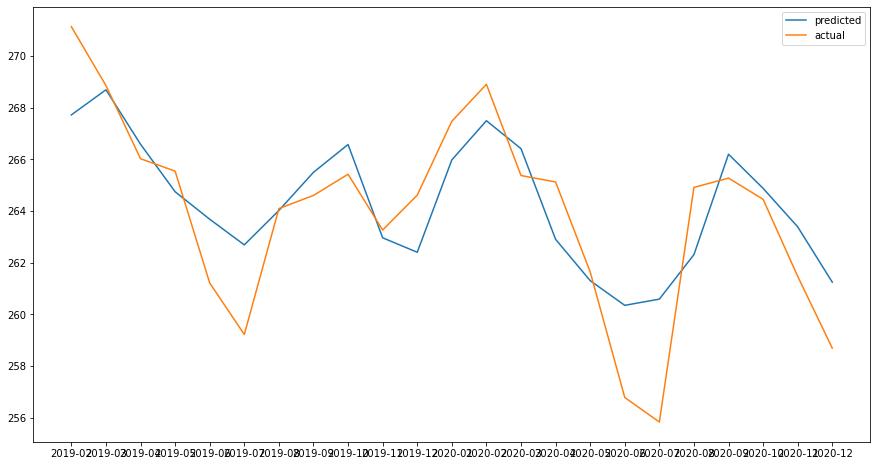

In [24]:
x1 = df_results['1']
x2 = df_test['1'][1:]
y = df_test.columns
plt.plot(x1,label = 'predicted')
plt.plot(x2,label = 'actual')
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import accuracy_score, mean_absolute_error
avg_acc = 0.0

for x in df_test.columns:
#     penalize = True
    c_acc = mean_absolute_error(df_test[x][1:], df_results[x])
    print(f'Column {x} mean absolute error: {c_acc}')
    avg_acc += c_acc/18

print("Average Mean absolute error of 18 columns = " + str(avg_acc))

Column 1 mean absolute error: 1.6841960343070663
Column 2 mean absolute error: 1.6643041461447075
Column 3 mean absolute error: 1.6941403596297575
Column 5 mean absolute error: 1.8645819091796885
Column 7 mean absolute error: 1.4538915750254784
Column 10 mean absolute error: 1.4492902938179322
Column 20 mean absolute error: 0.8328162682574711
Column 30 mean absolute error: 0.8251288903277834
Column 50 mean absolute error: 0.8141922395125654
Column 70 mean absolute error: 0.9794069771144704
Column 100 mean absolute error: 0.6770923913043493
Column 125 mean absolute error: 0.2631329080332853
Column 150 mean absolute error: 0.29619567871093816
Column 175 mean absolute error: 0.256707153320313
Column 200 mean absolute error: 0.2562402078379787
Column 225 mean absolute error: 0.30449582307235057
Column 250 mean absolute error: 0.36000573199728303
Column ENSO 3.4 Anomaly mean absolute error: 0.31640793204024104
Average Mean absolute error of 18 columns = 0.8884570288685367


In [29]:
def perc(a_list, b_list):
    ans = 0.0

    for i in range(len(a_list)):
        ans += (1. - abs(a_list[i]-b_list[i])/a_list[i])

    return ans

In [33]:
avg_acc = 0.0
for x in df_test.columns:
#     penalize = True
    c_acc = perc(df_test[x][1:], df_results[x])
    print(f'Column {x} Percentage Error: {c_acc}')
    avg_acc += c_acc/18

print("Average Percentage error of 18 columns = " + str(avg_acc))

Column 1 Percentage Error: 22.852405350555475
Column 2 Percentage Error: 22.851849140130504
Column 3 Percentage Error: 22.845693888990287
Column 5 Percentage Error: 22.82391605437582
Column 7 Percentage Error: 22.85852883301524
Column 10 Percentage Error: 22.85498811968252
Column 20 Percentage Error: 22.912309163854484
Column 30 Percentage Error: 22.91144398584821
Column 50 Percentage Error: 22.909014221824837
Column 70 Percentage Error: 22.886478258200516
Column 100 Percentage Error: 22.91937761517176
Column 125 Percentage Error: 22.969541982570178
Column 150 Percentage Error: 22.96694168118653
Column 175 Percentage Error: 22.97234145187002
Column 200 Percentage Error: 22.97325985574651
Column 225 Percentage Error: 22.969148721486345
Column 250 Percentage Error: 22.96443346532861
Column ENSO 3.4 Anomaly Percentage Error: 26.72106801033495
Average Percentage error of 18 columns = 23.12015221112071


In [36]:
from sklearn.metrics import r2_score
avg_acc = 0.0
for x in df_test.columns:
#     penalize = True
    c_acc = r2_score(df_test[x][1:], df_results[x])
    print(f'Column {x} R-Squared score: {c_acc}')
    avg_acc += c_acc/18

print("Average R2 score of 18 columns = " + str(avg_acc))

Column 1 R-Squared score: 0.6781863718661442
Column 2 R-Squared score: 0.6617177085451191
Column 3 R-Squared score: 0.6143907533142985
Column 5 R-Squared score: 0.460935812950207
Column 7 R-Squared score: 0.6040836254031922
Column 10 R-Squared score: 0.5195805668682905
Column 20 R-Squared score: 0.6223424818239759
Column 30 R-Squared score: 0.6839084500506767
Column 50 R-Squared score: 0.710350411077293
Column 70 R-Squared score: 0.8227323207947154
Column 100 R-Squared score: 0.6556374831104792
Column 125 R-Squared score: 0.601299528268016
Column 150 R-Squared score: 0.19519560487343912
Column 175 R-Squared score: 0.498238562694445
Column 200 R-Squared score: 0.5889173083370265
Column 225 R-Squared score: 0.5337196365232725
Column 250 R-Squared score: 0.3899756482187552
Column ENSO 3.4 Anomaly R-Squared score: 0.7359921897461581
Average R2 score of 18 columns = 0.5876224702480837
